In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

In [22]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 150)

In [12]:
def basic_EDA(dataset):
  print("=====================================1. Performing basic EDA=====================")
  if dataset.shape==(593, 78):
    curr_dataset = "emotions"
  elif dataset.shape==(2417, 117):
    curr_dataset = "yeast"
  else:
    curr_dataset = "bookmarks"
  print("==================Printing glimpse of dataset====================")
  print(dataset.head(5))
  print("=================================================================")
  print("")
  print("Shape of {} dataset: {}".format(curr_dataset,dataset.shape))
  print("")
  print("==================Printing information of each columns===========")
  print(dataset.info())
  print("=================================================================")
  print("")
  print("==================Analysing data distribution=========================")
  print(dataset.describe())

In [13]:
def plot_boxplots(dataset):
  print("=======================================2. plotting boxplots=============================")
  l = dataset.columns.values
  number_of_columns=8
  number_of_rows = len(l)-1/number_of_columns
  plt.figure(figsize=(number_of_columns*1.5,5*number_of_rows))
  for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(dataset[l[i]],color='green',orient='v')
    plt.tight_layout()

In [14]:
def plot_dist(dataset):
  print("=====================================3. Analysing data distribution========================")
  l = dataset.columns.values
  number_of_columns=8
  number_of_rows = len(l)-1/number_of_columns
  plt.figure(figsize=(1.5*number_of_columns,5*number_of_rows))
  for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(dataset[l[i]],kde=True)

In [15]:
def split_train_test(dataset):
  if dataset.shape==(593, 78):
    curr_dataset = "emotions"
    num_features = 72
    num_labels = 6
  elif dataset.shape==(2417, 117):
    curr_dataset = "yeast"
    num_features = 103
    num_labels = 14
  else:
    curr_dataset = "bookmarks"
    num_features = 2150
    num_labels = 208
  #print("num_features; {}, num_labels: {}".format(num_features,num_labels))  
  from sklearn.model_selection import train_test_split
  train, test = train_test_split(dataset, random_state=42, test_size=0.20, shuffle=True)
  x_train = train.iloc[:,0:num_features]
  y_train = train.iloc[:,-num_labels:]
  x_test = test.iloc[:,0:num_features]
  y_test = test.iloc[:,-num_labels:]
  print("x_train shape: {}, y_train shape: {}".format(x_train.shape,y_train.shape))
  print("x_test shape: {}, y_test shape: {}".format(x_test.shape,y_test.shape))
  return x_train,y_train,x_test,y_test

In [16]:
def normalize_data(x_train,x_test):
  from sklearn.preprocessing import MinMaxScaler
  x_scaler = MinMaxScaler(feature_range=(0,1))
  x_scaled_train =  np.float32(x_scaler.fit_transform(x_train))
  x_scaled_test = np.float32(x_scaler.fit_transform(x_test))
  print("x_scaled_train shape: {}, x_scaled_test shape: {}".format(x_scaled_train.shape,x_scaled_test.shape))
  return x_scaled_train,x_scaled_test

In [17]:
def basic_corr(dataset):
  print("===============================4. Perform basic correlation analysis across the dataset====================")
  print(dataset.corr())

In [18]:
def chi_sq_test(y_train):
  print("==============================5. Perform correlation analysis on labels====================================")
  from scipy.stats import chi2_contingency
  label_names = y_train.columns.values
  result = np.ndarray(shape=(len(label_names),len(label_names)), dtype=float)
  #print(result)

  
  p_value_list = []
  for i in range(len(label_names)):
    col1 = y_train.iloc[:,i]
    for j in range(len(label_names)):
      col2 = y_train.iloc[:,j]
      table = pd.crosstab(col1,col2)
      chi2, p , dof, expected = chi2_contingency(table.values)
      result[i][j] = p
      #print("({} - {}) p_value: {}".format(label_names[i],label_names[j],p))   
  #print(result)

  result_df = pd.DataFrame(data=result)
  result_df.columns = label_names
  result_df.index = label_names
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 1000)
  print("==========================results of chi_sq test==========================")
  print(result_df)
  print("")

  corr_table = np.ndarray(shape= (len(label_names),len(label_names)), dtype = np.int)
  for i in range(len(label_names)):
    for j in range(len(label_names)):
       corr_table[i][j] = result[i][j]<0.05
  #print(corr_table)

  df = pd.DataFrame(data=corr_table)
  df.columns = label_names
  df.index = label_names
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 1000)
  print("============================after thresholding=============================")
  print(df) 
  print("") 

Doing EDA on : emotions dataset
=====================================1. Performing basic EDA=====================
==================Printing glimpse of dataset====================
   Mean_Acc1298_Mean_Mem40_Centroid   Mean_Acc1298_Mean_Mem40_Rolloff   Mean_Acc1298_Mean_Mem40_Flux   Mean_Acc1298_Mean_Mem40_MFCC_0  \
0                          0.034741                          0.089665                       0.091225                       -73.302422   
1                          0.081374                          0.272747                       0.085733                       -62.584437   
2                          0.110545                          0.273567                       0.084410                       -65.235325   
3                          0.042481                          0.199281                       0.093447                       -80.305152   
4                          0.074550                          0.140880                       0.079789                       -93.697749  

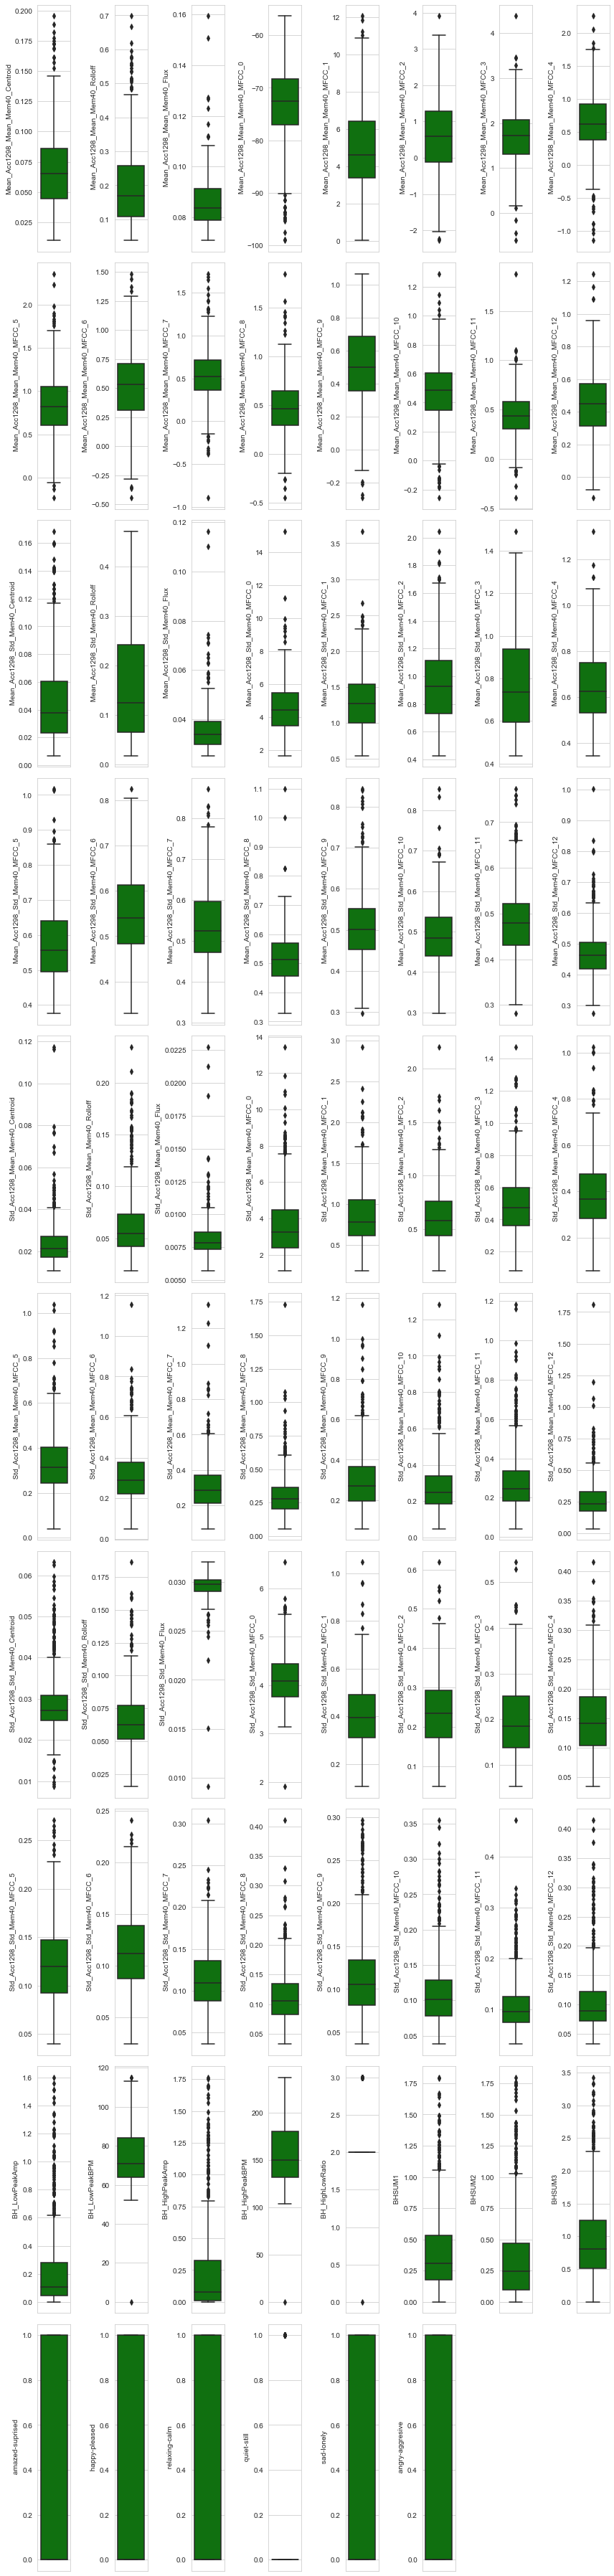

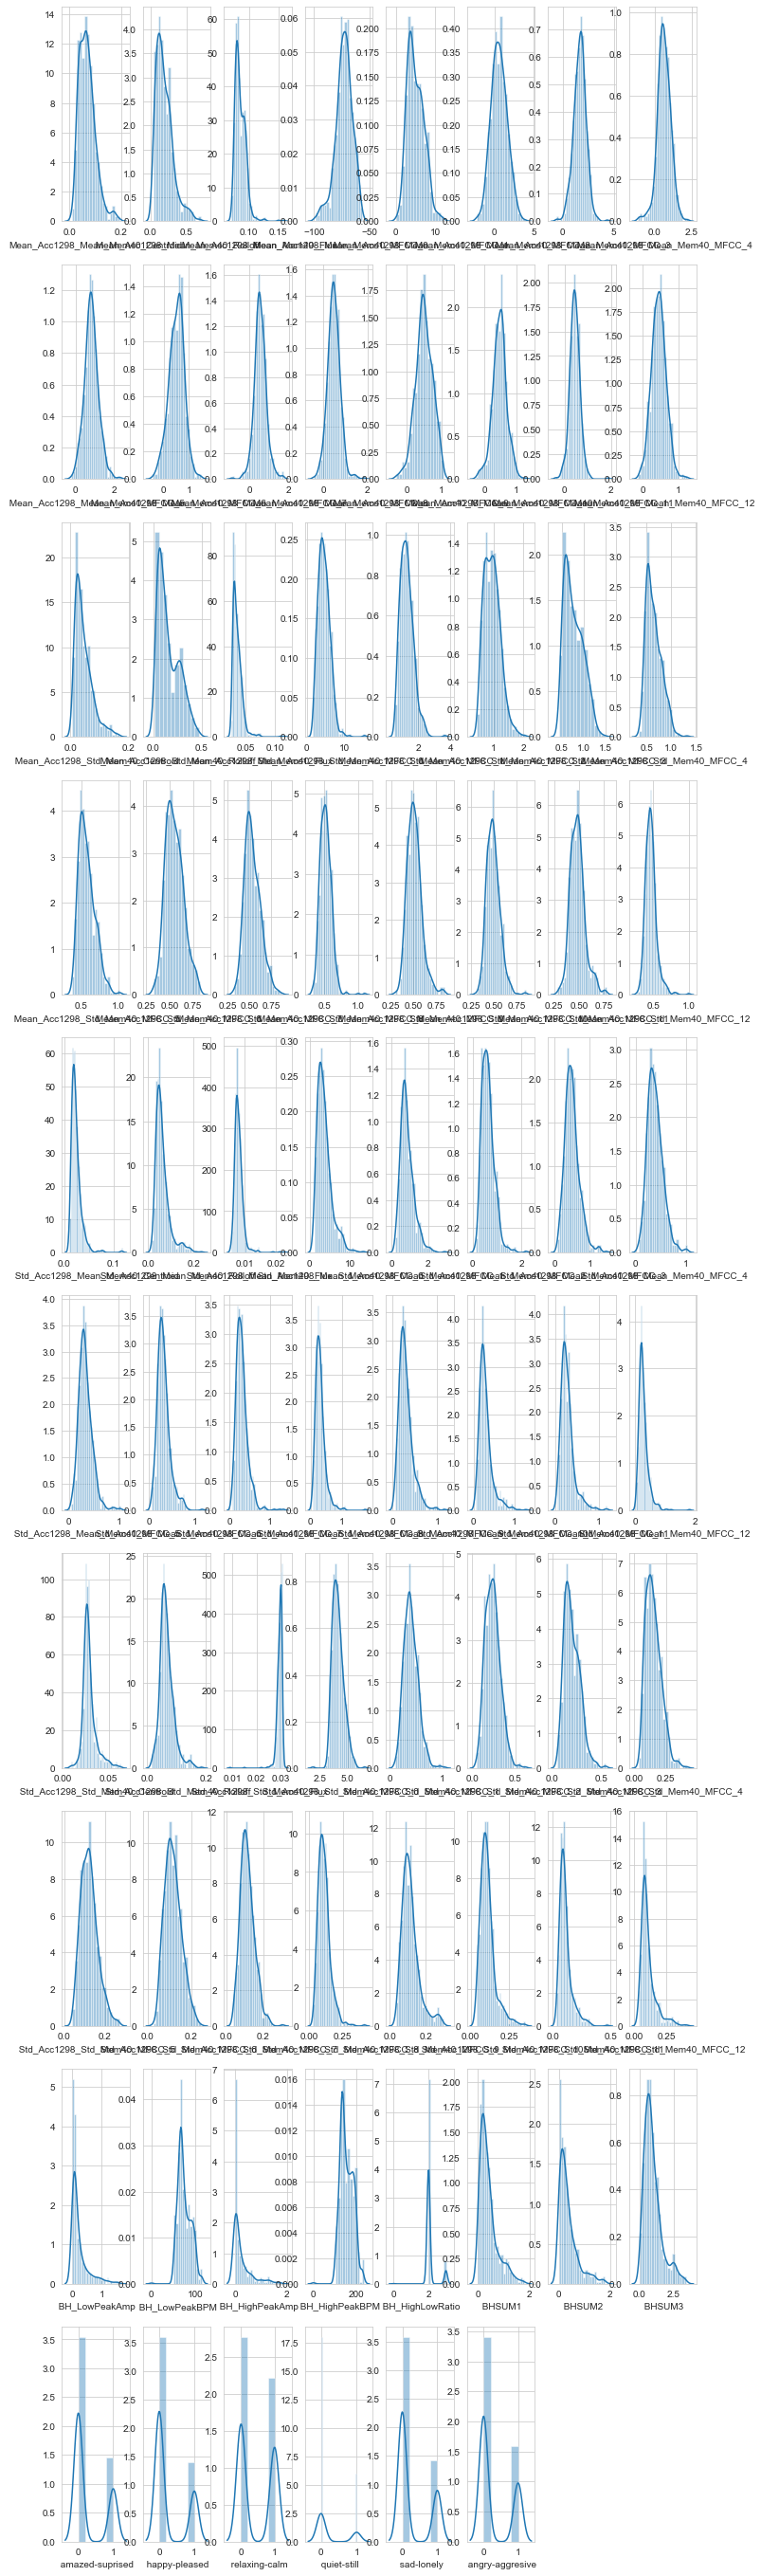

In [23]:
def main():
  dataset = ["emotions", "yeast","bookmarks"]
  perform_EDA = dataset[0]
  
  print("Doing EDA on : {} dataset".format(perform_EDA))
  if perform_EDA.lower() == "emotions":
    curr_dataset = pd.read_csv("emotions.csv") # 6 labels, 72 features
  elif perform_EDA.lower() == "yeast":
    curr_dataset = pd.read_csv("yeast.csv") # 14 labels, 103 features
  else:
    curr_dataset = pd.read_csv("bookmarks.csv") # 208 labels, 2150 features
  
  #perform basic EDA
  basic_EDA(curr_dataset)
  
  #plot boxplot
  plot_boxplots(curr_dataset)
  
  #plot data distribution
  plot_dist(curr_dataset)
  
  #train test split
  x_train,y_train,x_test,y_test = split_train_test(curr_dataset)
  x_scaled_train,x_scaled_test = normalize_data(x_train,x_test)
  
  #basic correlation
  basic_corr(curr_dataset)
  
  #corr analysis on target labels
  chi_sq_test(y_train)
  
  
if __name__ == '__main__':
  # parser = argparse.ArgumentParser()
  # parser.add_argument("dataset", type = str ,help = "Enter the dataset to perform EDA(emotions/yeast/bookmarks)")
  # args = parser.parse_args()
  # main(args.dataset)
  main()